# tf2.0でmnistの学習とGrad-CAMの実装

## 学習

### tfのversion確認

In [1]:
import tensorflow as tf
tf.__version__

'2.4.0'

### モデル定義

In [75]:
from tensorflow.keras import layers

class Classifier(tf.keras.Model):
  def __init__(self):
    super().__init__()
    # 使用するLayerの定義
    self.conv0 = layers.Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')
    self.mp0 = layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1')
    self.conv1 = layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu', name='conv_2')
    self.flatten = layers.Flatten()
    self.l1 = layers.Dense(128, activation='relu', name='dense_1')
    self.l2 = layers.Dense(10, activation='softmax', name='dense_2')
  
  def call(self, inputs):
    x = self.conv0(inputs)
    x = self.mp0(x)
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.l1(x)
    x = self.l2(x)

    return x
  
  '''
  subclassing apiではモデルのinputやoutputを明示してないため、
  のちのちmodel.get_layerを使用して中間層を取得できない。
  そのため、中間層を出力するメソッドを作成する。
  @tf.functionをつけることで計算グラフが構築された状態になるので、
  savedmodel形式で保存したときに、この関数まで保存されるのかな？
  @tf.functionつけないと後々メソッドが呼び出せない.
  追記：最終的に使わなかった、
  '''
  @tf.function(input_signature=[tf.TensorSpec([None, 28, 28, 1], tf.float32)])
  def get_conv1_output(self, inputs):
    x = self.conv0(inputs)
    x = self.mp0(x)
    conv1 = self.conv1(x)
    x = self.flatten(conv1)
    x = self.l1(x)
    x = self.l2(x)
    return x, conv1

### mnist_datasetの準備

In [28]:
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:,:,:, np.newaxis] / 255.0
x_test = x_test[:,:,:, np.newaxis] / 255.0
print(x_train.shape)
print(x_test.shape)

# tf.dataによるデータセット作成
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=60000).batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Main

In [76]:
model = Classifier()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc = tf.keras.metrics.SparseCategoricalAccuracy()
opt = tf.keras.optimizers.Adam()
EPOCH = 5

@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    pred = model(x)
    loss_val = loss(y, pred)

  # backward
  gradients = tape.gradient(loss_val, model.trainable_weights)
  # step optimizer
  opt.apply_gradients(zip(gradients, model.trainable_weights))
  # update accuracy
  train_acc.update_state(y, pred)

  return loss_val

@tf.function
def test_on_batch(x, y):
  pred = model(x)
  loss_val = loss(y, pred)
  test_acc.update_state(y, pred)
  return loss_val

# train
for i in range(EPOCH):
  # 評価関数のリセット
  train_acc.reset_states()
  test_acc.reset_states()
  print("Epoch=", i)

  for step, (x, y) in enumerate(train_dataset):
    loss_val = train_on_batch(x, y)

    print("\rstep={0}, loss={1}, total accuracy={2}".format(step, loss_val, train_acc.result()), end="")
  
  for (x, y) in test_dataset:
    loss_val = test_on_batch(x, y)
  print("\ntest_val={0}, test accuracy={1}".format(loss_val, test_acc.result()))

# save model
model.save('/content/drive/MyDrive/mnist/model/')

Epoch= 0
step=468, loss=0.04126186668872833, total accuracy=0.9223166704177856
test_val=0.030652616173028946, test accuracy=0.9688000082969666
Epoch= 1
step=468, loss=0.06372872740030289, total accuracy=0.973883330821991
test_val=0.0037276349030435085, test accuracy=0.9757999777793884
Epoch= 2
step=468, loss=0.1473265290260315, total accuracy=0.9814666509628296
test_val=0.0007890762062743306, test accuracy=0.9814000129699707
Epoch= 3
step=468, loss=0.07757005095481873, total accuracy=0.9851833581924438
test_val=0.0015517963329330087, test accuracy=0.9832000136375427
Epoch= 4
step=468, loss=0.026307426393032074, total accuracy=0.9882500171661377
test_val=0.0017825148534029722, test accuracy=0.984499990940094
INFO:tensorflow:Assets written to: /content/drive/MyDrive/mnist/model/assets


## Grad-CAM


### モデルの確認

In [77]:
import tensorflow as tf
model_path = "/content/drive/MyDrive/mnist/model"
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "classifier_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              multiple                  80        
_________________________________________________________________
maxpool_1 (MaxPooling2D)     multiple                  0         
_________________________________________________________________
conv_2 (Conv2D)              multiple                  2336      
_________________________________________________________________
flatten_19 (Flatten)         multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  200832    
_________________________________________________________________
dense_2 (Dense)              multiple                  1290      
Total params: 204,538
Trainable params: 204,538
Non-trainable params: 0
_______________________________________________

### Main

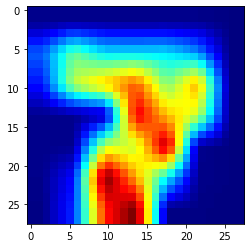

In [21]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class Grad_Model(tf.keras.Model):
  def __init__(self, t_model):
    super().__init__()
    # 使用するLayerの定義
    self.conv0 = t_model.conv0
    self.mp0 = t_model.mp0
    self.conv1 = t_model.conv1
    self.flatten = t_model.flatten
    self.l1 = t_model.l1
    self.l2 = t_model.l2

  def call(self, inputs):
    x = self.conv0(inputs)
    x = self.mp0(x)
    conv_out = self.conv1(x)
    x = self.flatten(conv_out)
    x = self.l1(x)
    x = self.l2(x)
    return x, conv_out # Grad-CAMで見たいconv層の出力も返す

def GradCam(model, img, label):
  grad_model = Grad_Model(model) # 勾配計算用にモデルを生成

  # 勾配の計算
  with tf.GradientTape() as tape:
    predictions, conv_outputs = grad_model(np.array([img]))
    class_out = predictions[:, label]
  output = conv_outputs[0]
  grads = tape.gradient(class_out, conv_outputs)[0]

  # ここの3文はよくわからなかった
  gate_f = tf.cast(output > 0, 'float32')
  gate_r = tf.cast(grads > 0, 'float32')
  guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

  weights = tf.reduce_mean(guided_grads, axis=(0, 1))

  cam = np.zeros(output.shape[0: 2], dtype = np.float32)

  for i, w in enumerate(weights):
      cam += w * output[:, :, i]

  # 得られたヒートマップを成形して画像として保存と表示
  cam = cv2.resize(cam.numpy(), (28, 28))
  cam = np.maximum(cam, 0)
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())

  cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  
  output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)
  
  cv2.imwrite('/content/drive/MyDrive/mnist/test.png', output_image)
  output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
  plt.imshow(output_image)
  plt.show()

def main():
  model_path = "/content/drive/MyDrive/mnist/model"
  model = tf.keras.models.load_model(model_path)

  (_,_), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_test = x_test[:,:,:, np.newaxis] / 255.0
  img = x_test[0]
  label = y_test[0]

  heatmap = GradCam(model, img, label)

if __name__ == "__main__":
  main()